# Count data processing

See `data/count/readme.md` for a detailed description of the count data. This script combine the historical data until 2021 `data/count_2021.xlsx` and merge with the raw Trektellen files since 2021 `data/raw_count/Trektellen_data_2422_{y}.xlsx` to produce the file `all_count_processed.csv` which is used in the model.


In [47]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Old data

Formatted manually


In [48]:
do = pd.concat(
    [
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="1966-2013"),
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="2014-2016"),
        pd.read_excel("../data/count/count_2021.xlsx", sheet_name="2017-2021"),
    ]
)

# Sort by date
do = do.sort_values("date")

# Compute start and end
do["startTime"] = pd.to_datetime(do["startTime"], format="%H:%M:%S").dt.time
do["start"] = do["date"] + pd.to_timedelta(do["startTime"].astype(str))
do["endTime"] = pd.to_datetime(do["endTime"], format="%H:%M:%S").dt.time
do["end"] = do["date"] + pd.to_timedelta(do["endTime"].astype(str))

# Keep only relevant column
do = do[["species", "date", "count", "start", "end"]]

# Generate the 0 species list within hour
# NOT DONE

# Sum count of same species-time interval
do = do.groupby(["species", "date", "start", "end"]).agg({"count": "sum"}).reset_index()

In [49]:
do[do.start >= do.end]

,species,date,start,end,count


## Trektellen data

Exported from website every year.

Read all file and merge into a single file.


In [50]:
dn = []
for y in range(2022, 2023):
    dnn = pd.merge(
        pd.read_excel(f"../data/count/raw_count/Trektellen_data_2422_{y}.xlsx"),
        pd.read_excel(f"../data/count/raw_count/Trektellen_headerdata_2422_{y}.xlsx"),
        left_on="countid",
        right_on="id",
    )
    dn.append(dnn)
dn = pd.concat(dn, ignore_index=True)

dn["startDay"] = pd.to_datetime(dn["start"])
dn["endDay"] = pd.to_datetime(dn["stop"])
dn["datetime"] = pd.to_datetime(dn["date"] + " " + dn["timestamp"])
dn["date"] = pd.to_datetime(dn["date"])

dn["count"] = dn["direction1"]  # + dn["direction2"]

dn = dn[["datetime", "date", "startDay", "endDay", "speciesid", "count"]]

Fix issue with datetime before start or after end

1. correct timing within 10 minute of start and end.
2. Ignore others.


In [51]:
# Entry which have a datetime before startDay, but only 10 minutes before
id = (dn["datetime"] < dn["startDay"]) & (
    abs(dn["datetime"] - dn["startDay"]) < pd.Timedelta(minutes=10)
)
dn.loc[id, "datetime"] = dn.loc[id, "startDay"] + pd.Timedelta(minutes=1)

# eEntry which have a datetime after endDay, but only max 10 minutes after
id = (dn["datetime"] >= dn["endDay"]) & (
    abs(dn["datetime"] - dn["endDay"]) < pd.Timedelta(minutes=10)
)
dn.loc[id, "datetime"] = dn.loc[id, "endDay"] - pd.Timedelta(minutes=1)

# Ignore the other data
id = (dn["datetime"] < dn["startDay"]) | (dn["datetime"] > dn["endDay"])
print(sum(id))
dn = dn[~id]

2


Create the start and end column to build list of 1hr


In [52]:
# compute the floor and ceil
dn["datetime_floor"] = dn["datetime"].dt.floor("h")
dn["datetime_ceil"] = dn["datetime"].dt.ceil("h")
# If datetime falls on the perfect hour, the ceil is actual staying on this number and we want to be on the next hour
dn.loc[dn["datetime_ceil"] == dn["datetime_floor"], "datetime_ceil"] += pd.Timedelta(
    hours=1
)

dn["start"] = dn[["datetime_floor", "startDay"]].max(axis=1)
dn["end"] = dn[["datetime_ceil", "endDay"]].min(axis=1)
dn["duration"] = dn["end"] - dn["start"]

In [53]:
dn[dn["duration"] < pd.to_timedelta(60 * 10, unit="s")]

,datetime,date,startDay,endDay,speciesid,count,datetime_floor,datetime_ceil,start,end,duration
855,2022-08-14 07:58:51,2022-08-14,2022-08-14 07:51:00,2022-08-14 11:10:00,107,0,2022-08-14 07:00:00,2022-08-14 08:00:00,2022-08-14 07:51:00,2022-08-14 08:00:00,0 days 00:09:00
1010,2022-08-21 19:00:27,2022-08-21,2022-08-21 07:29:00,2022-08-21 19:05:00,86,11,2022-08-21 19:00:00,2022-08-21 20:00:00,2022-08-21 19:00:00,2022-08-21 19:05:00,0 days 00:05:00
1045,2022-08-21 19:04:00,2022-08-21,2022-08-21 07:29:00,2022-08-21 19:05:00,95,1,2022-08-21 19:00:00,2022-08-21 20:00:00,2022-08-21 19:00:00,2022-08-21 19:05:00,0 days 00:05:00
1046,2022-08-21 19:04:00,2022-08-21,2022-08-21 07:29:00,2022-08-21 19:05:00,95,1,2022-08-21 19:00:00,2022-08-21 20:00:00,2022-08-21 19:00:00,2022-08-21 19:05:00,0 days 00:05:00
6068,2022-10-08 19:01:39,2022-10-08,2022-10-08 07:38:00,2022-10-08 19:05:00,28,10,2022-10-08 19:00:00,2022-10-08 20:00:00,2022-10-08 19:00:00,2022-10-08 19:05:00,0 days 00:05:00
6188,2022-10-08 19:01:14,2022-10-08,2022-10-08 07:38:00,2022-10-08 19:05:00,289,0,2022-10-08 19:00:00,2022-10-08 20:00:00,2022-10-08 19:00:00,2022-10-08 19:05:00,0 days 00:05:00


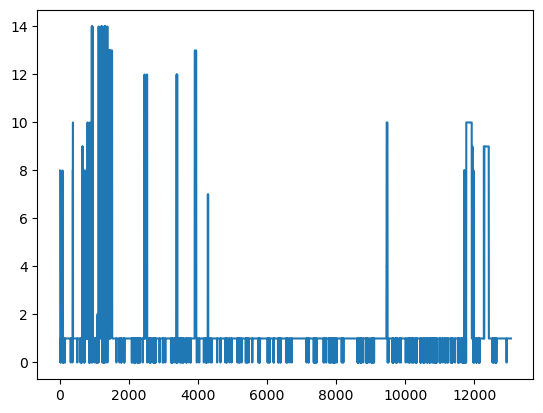

In [54]:
plt.plot((dn["duration"]).astype("timedelta64[s]") / 60 / 60)

Add taxonomy information to retrieve species name similar to old data.

In [55]:
dn

,datetime,date,startDay,endDay,speciesid,count,datetime_floor,datetime_ceil,start,end,duration
0,NaT,2022-07-18,2022-07-18 09:05:00,2022-07-18 17:35:00,88,11,NaT,NaT,2022-07-18 09:05:00,2022-07-18 17:35:00,0 days 08:30:00
1,NaT,2022-07-18,2022-07-18 09:05:00,2022-07-18 17:35:00,88,126,NaT,NaT,2022-07-18 09:05:00,2022-07-18 17:35:00,0 days 08:30:00
2,NaT,2022-07-18,2022-07-18 09:05:00,2022-07-18 17:35:00,89,1,NaT,NaT,2022-07-18 09:05:00,2022-07-18 17:35:00,0 days 08:30:00
3,NaT,2022-07-18,2022-07-18 09:05:00,2022-07-18 17:35:00,249,7,NaT,NaT,2022-07-18 09:05:00,2022-07-18 17:35:00,0 days 08:30:00
4,2022-07-19 12:53:38,2022-07-19,2022-07-19 09:00:00,2022-07-19 17:35:00,88,1,2022-07-19 12:00:00,2022-07-19 13:00:00,2022-07-19 12:00:00,2022-07-19 13:00:00,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...
13059,2022-10-02 17:11:55,2022-10-02,2022-10-02 07:17:00,2022-10-02 19:06:00,89,12,2022-10-02 17:00:00,2022-10-02 18:00:00,2022-10-02 17:00:00,2022-10-02 18:00:00,0 days 01:00:00
13060,2022-10-02 17:34:04,2022-10-02,2022-10-02 07:17:00,2022-10-02 19:06:00,89,33,2022-10-02 17:00:00,2022-10-02 18:00:00,2022-10-02 17:00:00,2022-10-02 18:00:00,0 days 01:00:00
13061,2022-10-02 17:37:15,2022-10-02,2022-10-02 07:17:00,2022-10-02 19:06:00,763,60,2022-10-02 17:00:00,2022-10-02 18:00:00,2022-10-02 17:00:00,2022-10-02 18:00:00,0 days 01:00:00
13062,2022-10-02 17:39:01,2022-10-02,2022-10-02 07:17:00,2022-10-02 19:06:00,282,2,2022-10-02 17:00:00,2022-10-02 18:00:00,2022-10-02 17:00:00,2022-10-02 18:00:00,0 days 01:00:00


In [56]:
dnt = pd.merge(
    dn,
    pd.read_csv(f"../data/taxonomy.csv")[["trektellen_species_id", "English name"]],
    how="left",
    left_on="speciesid",
    right_on="trektellen_species_id",
    indicator=True,
)
dnt["species"] = dnt["English name"]
# Debug species
# print(df[["speciesname", "speciesid"]][df["species"].isna()].drop_duplicates())

In [57]:
dnt[["species", "date", "count", "start", "end"]]

,species,date,count,start,end
0,Black Kite,2022-07-18,11,2022-07-18 09:05:00,2022-07-18 17:35:00
1,Black Kite,2022-07-18,126,2022-07-18 09:05:00,2022-07-18 17:35:00
2,Red Kite,2022-07-18,1,2022-07-18 09:05:00,2022-07-18 17:35:00
3,Common Swift,2022-07-18,7,2022-07-18 09:05:00,2022-07-18 17:35:00
4,Black Kite,2022-07-19,1,2022-07-19 12:00:00,2022-07-19 13:00:00
...,...,...,...,...,...
13057,Red Kite,2022-10-02,12,2022-10-02 17:00:00,2022-10-02 18:00:00
13058,Red Kite,2022-10-02,33,2022-10-02 17:00:00,2022-10-02 18:00:00
13059,swallow sp.,2022-10-02,60,2022-10-02 17:00:00,2022-10-02 18:00:00
13060,Western Yellow Wagtail,2022-10-02,2,2022-10-02 17:00:00,2022-10-02 18:00:00


## Merge Old and Trektellen data


In [58]:
don = pd.concat(
    [do, dnt[["species", "date", "count", "start", "end"]]], ignore_index=True
)

In [59]:
don.to_csv("../data/count/all_count_processed.csv", index=False)

---

## Visual

### Species

Filter list of species for raptor species (non-slash/spuh). The only issue would be Red/Black Kite, Buteo sp. and Buse ou Bondrée


In [60]:
tax = pd.read_csv("../data/taxonomy.csv")
tax = tax[
    tax["family"].isin(
        [
            "Accipitridae (Hawks, Eagles, and Kites)",
            "Pandionidae (Osprey)",
            "Falconidae (Falcons and Caracaras)",
        ]
    )
]
tax = tax[tax["category"] == "species"]
tax

,species,trektellen_species_id,match_to_ebird,species_code,taxon_concept_id,category,English name,scientific name,order,family
1,Aigle botté,NaN,exact,booeag1,avibase-4B8CC285,species,Booted Eagle,Hieraaetus pennatus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
2,Aigle criard,NaN,exact,grseag1,avibase-BAC4CA22,species,Greater Spotted Eagle,Clanga clanga,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
3,Aigle des steppes,NaN,exact,steeag1,avibase-A635F565,species,Steppe Eagle,Aquila nipalensis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
6,Aigle pomarin,NaN,exact,leseag1,avibase-C2565B65,species,Lesser Spotted Eagle,Clanga pomarina,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
8,Aigle royal,107.0,exact,goleag,avibase-5F8E7CA8,species,Golden Eagle,Aquila chrysaetos,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
16,Autour des palombes,99.0,exact,norgos1,avibase-95DD1855,species,Eurasian Goshawk,Accipiter gentilis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
18,Balbuzard pêcheur,109.0,exact,osprey,avibase-1327AC55,species,Osprey,Pandion haliaetus,Accipitriformes,Pandionidae (Osprey)
31,Bondrée apivore,86.0,exact,euhbuz1,avibase-ED5A7E8F,species,European Honey-buzzard,Pernis apivorus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
41,Busard cendré,98.0,exact,monhar1,avibase-63B6412E,species,Montagu's Harrier,Circus pygargus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
42,Busard des roseaux,95.0,exact,wemhar1,avibase-E2A19474,species,Western Marsh Harrier,Circus aeruginosus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"


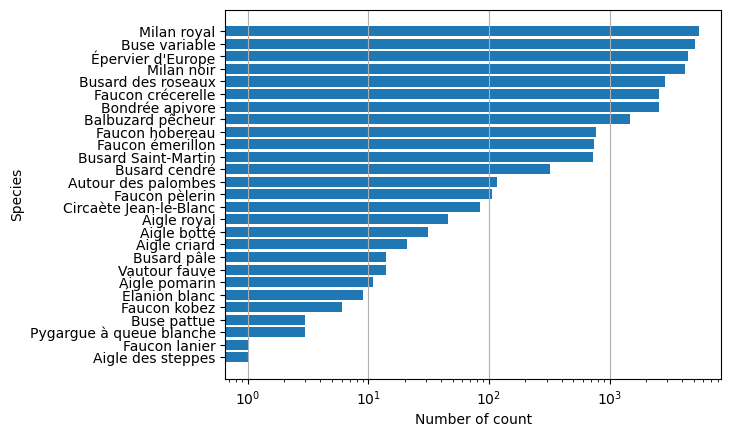

In [61]:
species_counts = don[don.species.isin(tax.species)].species.value_counts()
plt.barh(species_counts.index, species_counts.values, log=True)
plt.ylabel("Species")
plt.xlabel("Number of count")
plt.gca().invert_yaxis()
plt.gca().grid(axis="x")
plt.show()